# Hacking The IT Industry
**Characterizing the Philippine's IT industry based on skillsets, technologies and functions.**

## Executive Summary

The increase in popularity of digitization, the continuous technological advancements and the emergence of artificial intelligence have made jobs from the IT industry to be one of the most in-demand in the Philippines. To meet this demand, this study aims to discover the skills needed to be hired in the IT industry in the Philippines. Using data gathered from several job-posting sites, Non-negative Matrix Factorization (NMF) method was used to cluster and pinpoint the relevant competencies needed for IT jobs in the country. Results show that as of June 2019, the IT industry in the Philippines has 25 clusters based on the required skill set, with skills related to system administration, network engineering and tech support being the top 3 most in demand at least for the second quarter of 2019.

## Introduction

The Information Technology (IT) industry has served as one of the top contributors to the economy of the Philippines for the past decade. The increase in popularity of digitization, along with the emergence of artificial intelligence, have made jobs from the IT industry to be one of the most in-demand out of all the industries in the country. Unfortunetely, studies have shown that most IT graduates lack the necessary skills to work in this industry. Additional training must be done before these graduates are employable.

In order to prepare for the fourth industrial revolution, it is imperative to identify the skills needed to be in the IT industry and prepare our students accordingly. The aim of this study is to identify the skills required in the current IT job market. This was done by extracting information from several job-posting sites and attempting to classify the different skill sets demanded by the industry landscape.

## Data Gathering

The researchers gathered scraped around 5600 IT related job posts from 4 different job posting sites, namely: MonsterJobs, ICTjobs, CareerJet and Indeed. The researchers were not able to scrape from JobStreet due to a firewall that is exhaustive and blocks any form of automated crawling; so exhaustive that even professional web scrapers were not able to scrape it. With that said, the data gathered from alternative websites are fewer but just as valid. And may serve as substitutes as the websites from which the data came from are all legitimate and recognized. 

Multiple scraping codes were made to be able to scrape the 4 job posting sites. The researchers will not be including the scraping code in this final paper but the scraping codes themselves are located in the scraping files directory.

**All the following codes below are for processing and analysis.**

## Import Packages

In [1]:
import wordcloud
import pandas as pd
import re
from ast import literal_eval
from functools import reduce
from collections import Counter
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from gensim.models import Word2Vec
from itertools import combinations
from nltk.corpus import stopwords
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.axes_grid.inset_locator import InsetPosition

from final_project_aux import DF_Text
from final_project_aux import TopicModel

C:\Users\Nigel\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Nigel\Anaconda3\lib\site-packages\mpl_toolkits\axes_grid\__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


## Declaration of Ploting Functions

These functions will be used for visualization.

In [3]:
def plot_coherence(k_values, coherences):
    '''Plots the coherence score for each k_value.
    
    Parameters:
    -----------
        k_values: list of integers
            Number of topics.
        coherences: list of float
            Coherence score of each k_value.
    '''
    matplotlib.rcParams.update({"font.size": 14})

    fig = plt.figure(figsize=(13,7))
    # create the line plot
    ax = plt.plot(k_values, coherences )
    plt.xticks(k_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    # add the points
    plt.scatter( k_values, coherences, s=120)
    # find and annotate the maximum point on the plot
    ymax = max(coherences)
    xpos = coherences.index(ymax)
    best_k = k_values[xpos]
    plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
    # show the plot
    plt.show()

def plot_wordcloud(topic):
    '''Plots the word cloud of the topic (our sub-reddit) based 
    on the titles associated with that sub-reddit.
    
    Parameters:
    -----------
        topic: string
            Large string of titles.
    '''

    plt.rcParams['figure.figsize'] = (12.0, 8.0)
    wordcloud = WordCloud(max_font_size=70, max_words=100, width=800, height=400, background_color="white").generate(topic)
    plt.figure(figsize=[12,10], dpi=300)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
def kde_weights(df, col_sanity, col_list, zoom=[-1,11,-0.03,0.37], posi=[0.45,0.3,0.5,0.5]):
    '''Create a kde plot of the distribution of the weights of a cluster vs the other possible weights
    if the description was clustered in the other topic.
    
    This shows how defined the topic is (which can be a basis for extra cleaning).
    It also shows a comparison of weights for overlapping topics. 
    
    Parameters:
    -----------
        df: dataframe
            Contains the weights to plot
        col_sanity: string
            Column to compare the weights to
        col_list: list
            Columns to compare
        zoom: list
            List of coordinates in the form: ylim_start, ylim_end, xlim_start, xlim_end
        posi: list
            List of coordinates where the inset plot is anchored to.
    '''

    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    dat1 = df[df['label']==col_sanity][col_sanity]
    dat1.plot.kde(ax=ax)
    
    for col in col_list:
        dat1 = df[df['label']==col_sanity][col]
        dat1.plot.kde(ax=ax)

    ax.legend()
    ax.set_title(f'{col_sanity} weight on other clusters')
    ax.set_xlabel('Weight Of Membership')

    # Create a set of inset Axes: filling the bounding box
    ax2 = plt.axes([0,0,1,1])
    
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax, posi)
    ax2.set_axes_locator(ip)
    
    dat1 = df[df['label']==col_sanity][col_sanity]
    dat1.plot.kde(ax=ax2)
    
    for col in col_list:
        dat1 = df[df['label']==col_sanity][col]
        dat1.plot.kde(ax=ax2)
        
    ax2.set_ylim(zoom[0],zoom[1])
    ax2.set_xlim(zoom[2],zoom[3])
    ax2.set_title('Zoomed In')
    ax2.set_xlabel('Weight Of Membership')
    
    plt.show()
    
def top_clusters(df_lab_cnt):
    df_lab_cnt = df_lab_cnt.sort_values(by='title',ascending=False)
    stat = list(100*(df_lab_cnt['title']/df_lab_cnt['title'].sum()))

    x = [0,1,2,3,4,5,6,7,8,9,10,
         11,12,13,14,15,16,17,18,
         19,20,21,22,23,24,25]

    xt = [0.5,1.5,2.5,3.5,4.5,5.5,
          6.5,7.5,8.5,9.5,10.5,11.5,
          12.5,13.5,14.5,15.5,16.5,
          17.5,18.5,19.5,20.5,21.5,
          22.5,23.5,24.5,25.5]

    xy = list(zip(x,list(df_lab_cnt['title'].cumsum()/df_lab_cnt['title'].sum())))
    xty = list(zip(xt,list(df_lab_cnt['title'].cumsum()/df_lab_cnt['title'].sum())))

    fig, ax = plt.subplots(figsize=(10,8), dpi=100)
    
    ax.plot(np.arange(len(df_lab_cnt)),list(df_lab_cnt['title'].cumsum()/df_lab_cnt['title'].sum()), '-o')
    ax.set_xticks(x);
    ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]);
    # ax.grid()
    ax.set_title('Top 10 IT Skill Clusters')
    ax.axvline(9, color='blue')
    
    for i in range(10):
        ax.annotate(f'{df_lab_cnt.index[i]} ({round(stat[i],3)}%)', xy[i], xty[i])

    plt.show()

## EDA

The researchers began the exploratory analysis by checking out the location wherein wich the job openings exists. However, it can be seen that practically all the IT job openings are in Metro Manila.

### Location

In [7]:
df1 = pd.read_csv(r'Scraping Files/Summaries/Summary-06-18-2019-00-48-43.csv')
df1['description'] = df1['description'].astype(str)
df1['location'] = df1['location'].apply(lambda x: str(x).replace('City','').strip().lower())
df1['location'] = df1['location'].apply(lambda x: str(x).replace('/ ncr','').strip())
df1['location'] = df1['location'].apply(lambda x: str(x).replace('other -','').strip())
df1['location'] = df1['location'].apply(lambda x: str(x).replace('national capital region','metro manila').strip())
df1['location'] = df1['location'].apply(lambda x: str(x).replace(',  philippines','').strip())

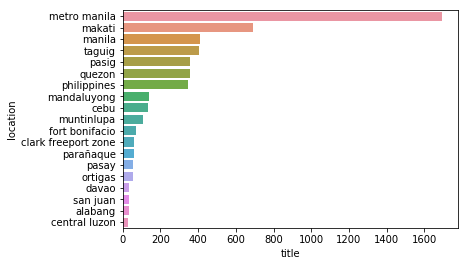

In [8]:
dflocations = df1.groupby('location').count().sort_values(by='title', ascending=False)
dflocations = dflocations.reset_index()
dflocations = dflocations.iloc[0:19]
sns.barplot(dflocations['title'], dflocations['location'])

### Word Cloud: Raw

A word cloud of the raw unprocessed description was made and it can be seen that there is little to no specific skills, tech and function among the most frequently used words. This was expected as the data is very noisy by nature since job posts don't follow any specific format.

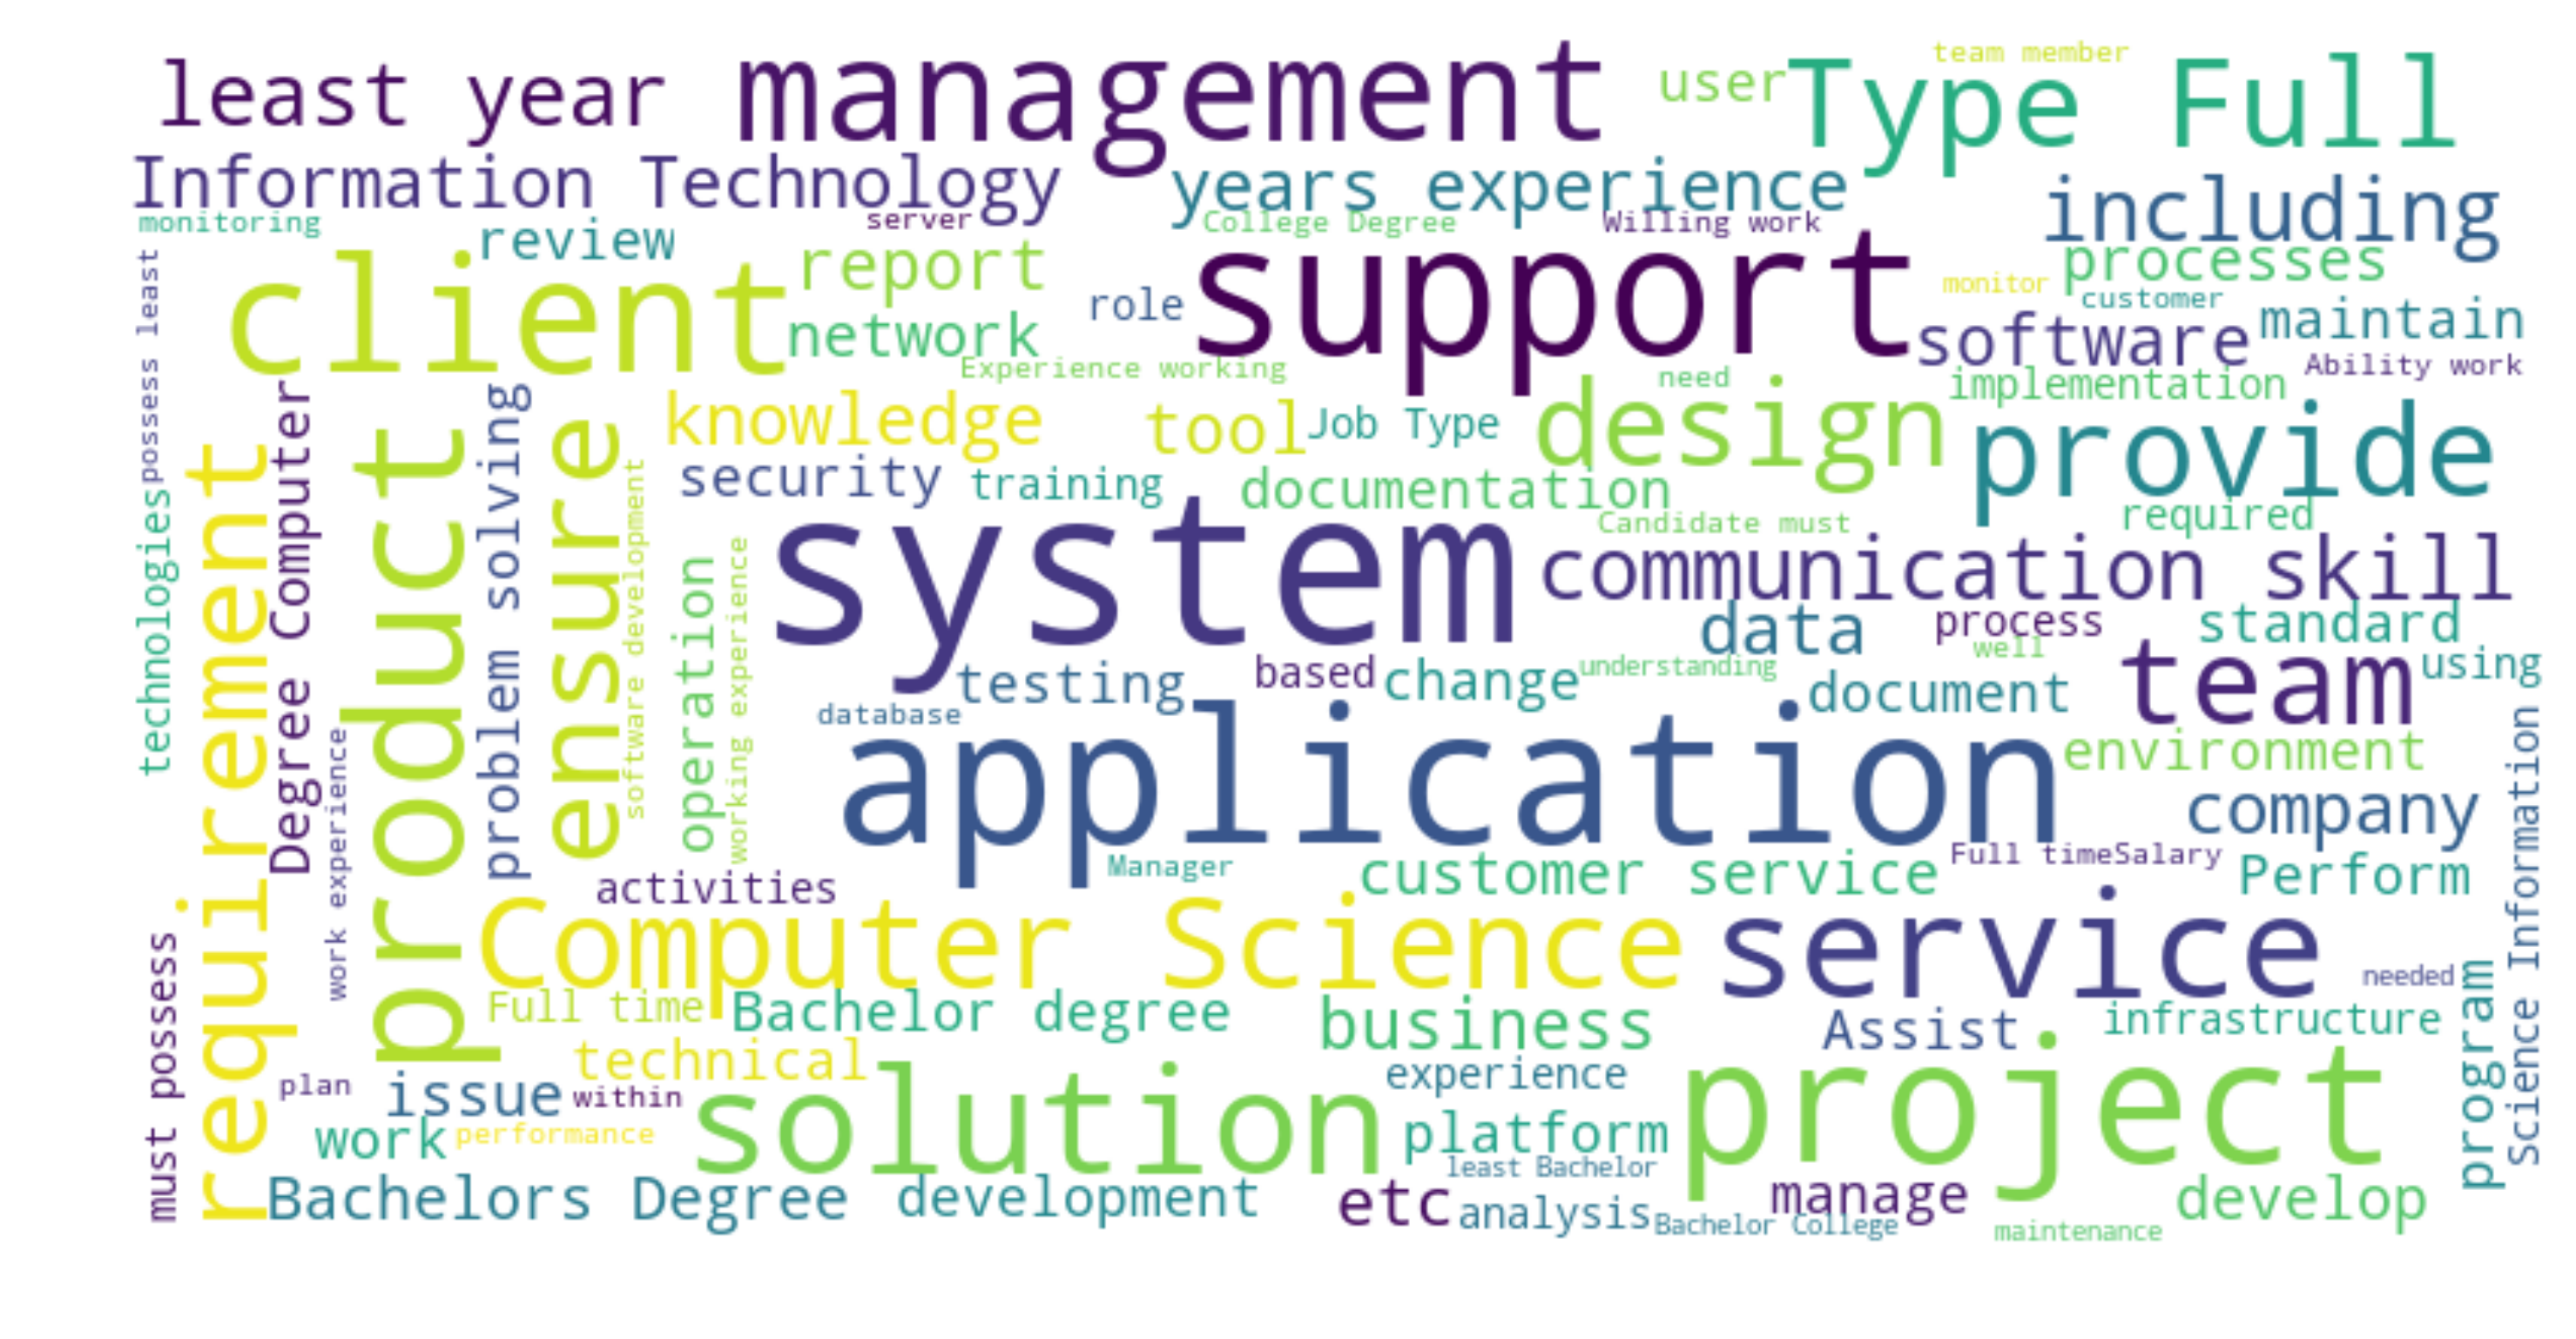

In [146]:
all_desc = ' '.join(df1['description'])
plot_wordcloud(all_desc)

## Cleaning: Description

The researchers created a package named `DF_Text` to make the cleaning codes more compact for the purpose of this paper. 

`DF_Text` has a number of method calls for cleaning:
* `col_clean` lowers the text and cleans the specified column via the word token specified.
    * For this case the researchers define words as a set of characters with at least a length of 1 from a to z and with symbols such as + and #.
* `col_stemmer`: trims the words down to their base form (this makes words like run and runs mean the same).
    * The researchers decided to use `stemming` so as to ensure that the words with different structure (but essentially same meaning) are counted as 1 upon vectorization.

The act of `tokenizing` and `stemming` essentially reduces the number of words that need to be processed and makes the "topic" of each job post clearer mathematically which allows for better clusters.

In [13]:
df = df1.drop_duplicates()
df = DF_Text(df, token=r"[a-z+#]+").col_clean('description')
df = DF_Text(df).col_stemmer('description_cleaned')

C:\Users\Nigel\Documents\AIM MSDS\Data Mining And Wrangling\DMW Final Project\FinalProject.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df[col+'_cleaned'] = self.df[col].apply(lambda x: x.lower())
C:\Users\Nigel\Documents\AIM MSDS\Data Mining And Wrangling\DMW Final Project\FinalProject.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  col+'_cleaned'].apply(lambda x: self._clean_rmv_stp(x))
C:\Users\Nigel\Documents\AIM MSDS\Data Mining And Wrangling\DMW Final Project\FinalProject.py:175: SettingWithCopyWarning: 
A value is t

### Custom Stop Words Library

The researchers created a custom stop words library **using the stemmed** words. This is because it is the stemmed words that are used as features for clustering. These stop words will be removed from the stemmed job descriptions prior to clustering to better the results. 

The stop words library is updated continously after each trial run. These words were chosen from the `top 10 defining words` of each clusters. These words were determined to be stop words based on the context of their clusters; **if the word doesn't fit the cluster's context then it is a stop word.**

In [14]:
custom_stop = {"team","opportun", "work","us","compani","help","global","career","ncr","make","look","world","manulif","hr",
               "candid","hire","sourc","employe","human","job","interview","believ","peopl","equal","wide","disciplin","futur",
               "enabl","world","influenc","special","gender","type","year","full","timeexperi","prefer","locat","tagalog",
               "relat","job","timesalari","monthexperi","type","full","year","prefer","requir","job","month","montheduc",
               "skill","abil","strong", "good","experi","work","team","ensur","requir","tinyurl","https","com","must","least",
               "equival","possess","colleg","candid","center","global","floor","citi","brilliant","transpar","shaw","outsourc",
               "space","ground","judgement", "passion", "happi", "bonifacio", "ortiga", "eastwood","time","group","individu","valu",
               "offic","yrs","www","linkedin","send","lead","best","ibm","employ","optum","watson","countri","willi","salari","knowledg", 
               "pleas","resum","resourc","benefit","educ","posit","degre","bachelor","sciencewith","modificationfront","reportspo",
               "closingprepar", "sexual","veteran","race","religion","agenc","makati","hour","differ","learn","understand",
               "fresh","graduat","cours","timeeduc","welcom","bs","hmo","via","homecredit","ph","home","aig","gax","fieldcomput",
               "oldcandid","shootingwith","layoutsword","certificatesnot","charactercan","proficientgraph","also",
               "need","taskus","someon","differ","paranaqu","person","student","school","monthexperience","salary","function",
               "unit","comput","printer","inform","scienc","technolog","graduate","experienc","brand","growth","australian",
               "http","staf","monthloc","qualif","twitter","graveyard","asapjob","fieldswith","shift", "perform","suzett", 
               "field", "provid", "prepar", "develop", "tax", "within", 'sr', 'p', 'n', 'yc', 'j', 'k', 'implement', 'quezon', "problem", 
               "innov", "challeng", "deliv", "role", "process", "busi", "var", "yb", "h", "chang", "deliveri", "relationship", "specif", 
               "nation", "color", "yd", "divers", "ya", "american", "continu", "anyth", "environ", "skillsjob", "bsit", "courseat",
               "undertak", "meet", "deliver","enginesagre","documentationprovid","productswrit","procedurespres",
               "efficientus","managersmaintain","requirementsmeasur","health","life","disabl","realiz","enterpris",
               "hope","occasion","trainabl","buyer","water","move","immedi","bond","hous","permit","toronto","hancock","john","canada"
               "billion","state""regard","issuanc","intern", "e","desk","product","design","corpor", "collabor","product","review", "w", 
               "telecommun", "contribut", "execut","new", "bpo", "leverag", "impact", "profession", "u", "program", "plus", "start",
               "concernsjob","troubleshootingprovid","requirementsgradu","laguna","generat","organ","architectur","applic","estim",
               "general","goal","b","outbound","inbound","handl","snapshot","master","use","one","everi","day", "pasig","contractsalari",
               "expertis"}

The cell below cleans the columns via the stop words specified above.

In [15]:
df = DF_Text(df, token=r"[a-z+#]+", cstm_stop=custom_stop).col_clean('description_cleaned_stemmed')
df = df[['title', 'company', 'location', 'description', 'bullets',
       'description_cleaned', 'description_cleaned_stemmed',
       'description_cleaned_stemmed_cleaned']]
df = df.reset_index(drop=True)

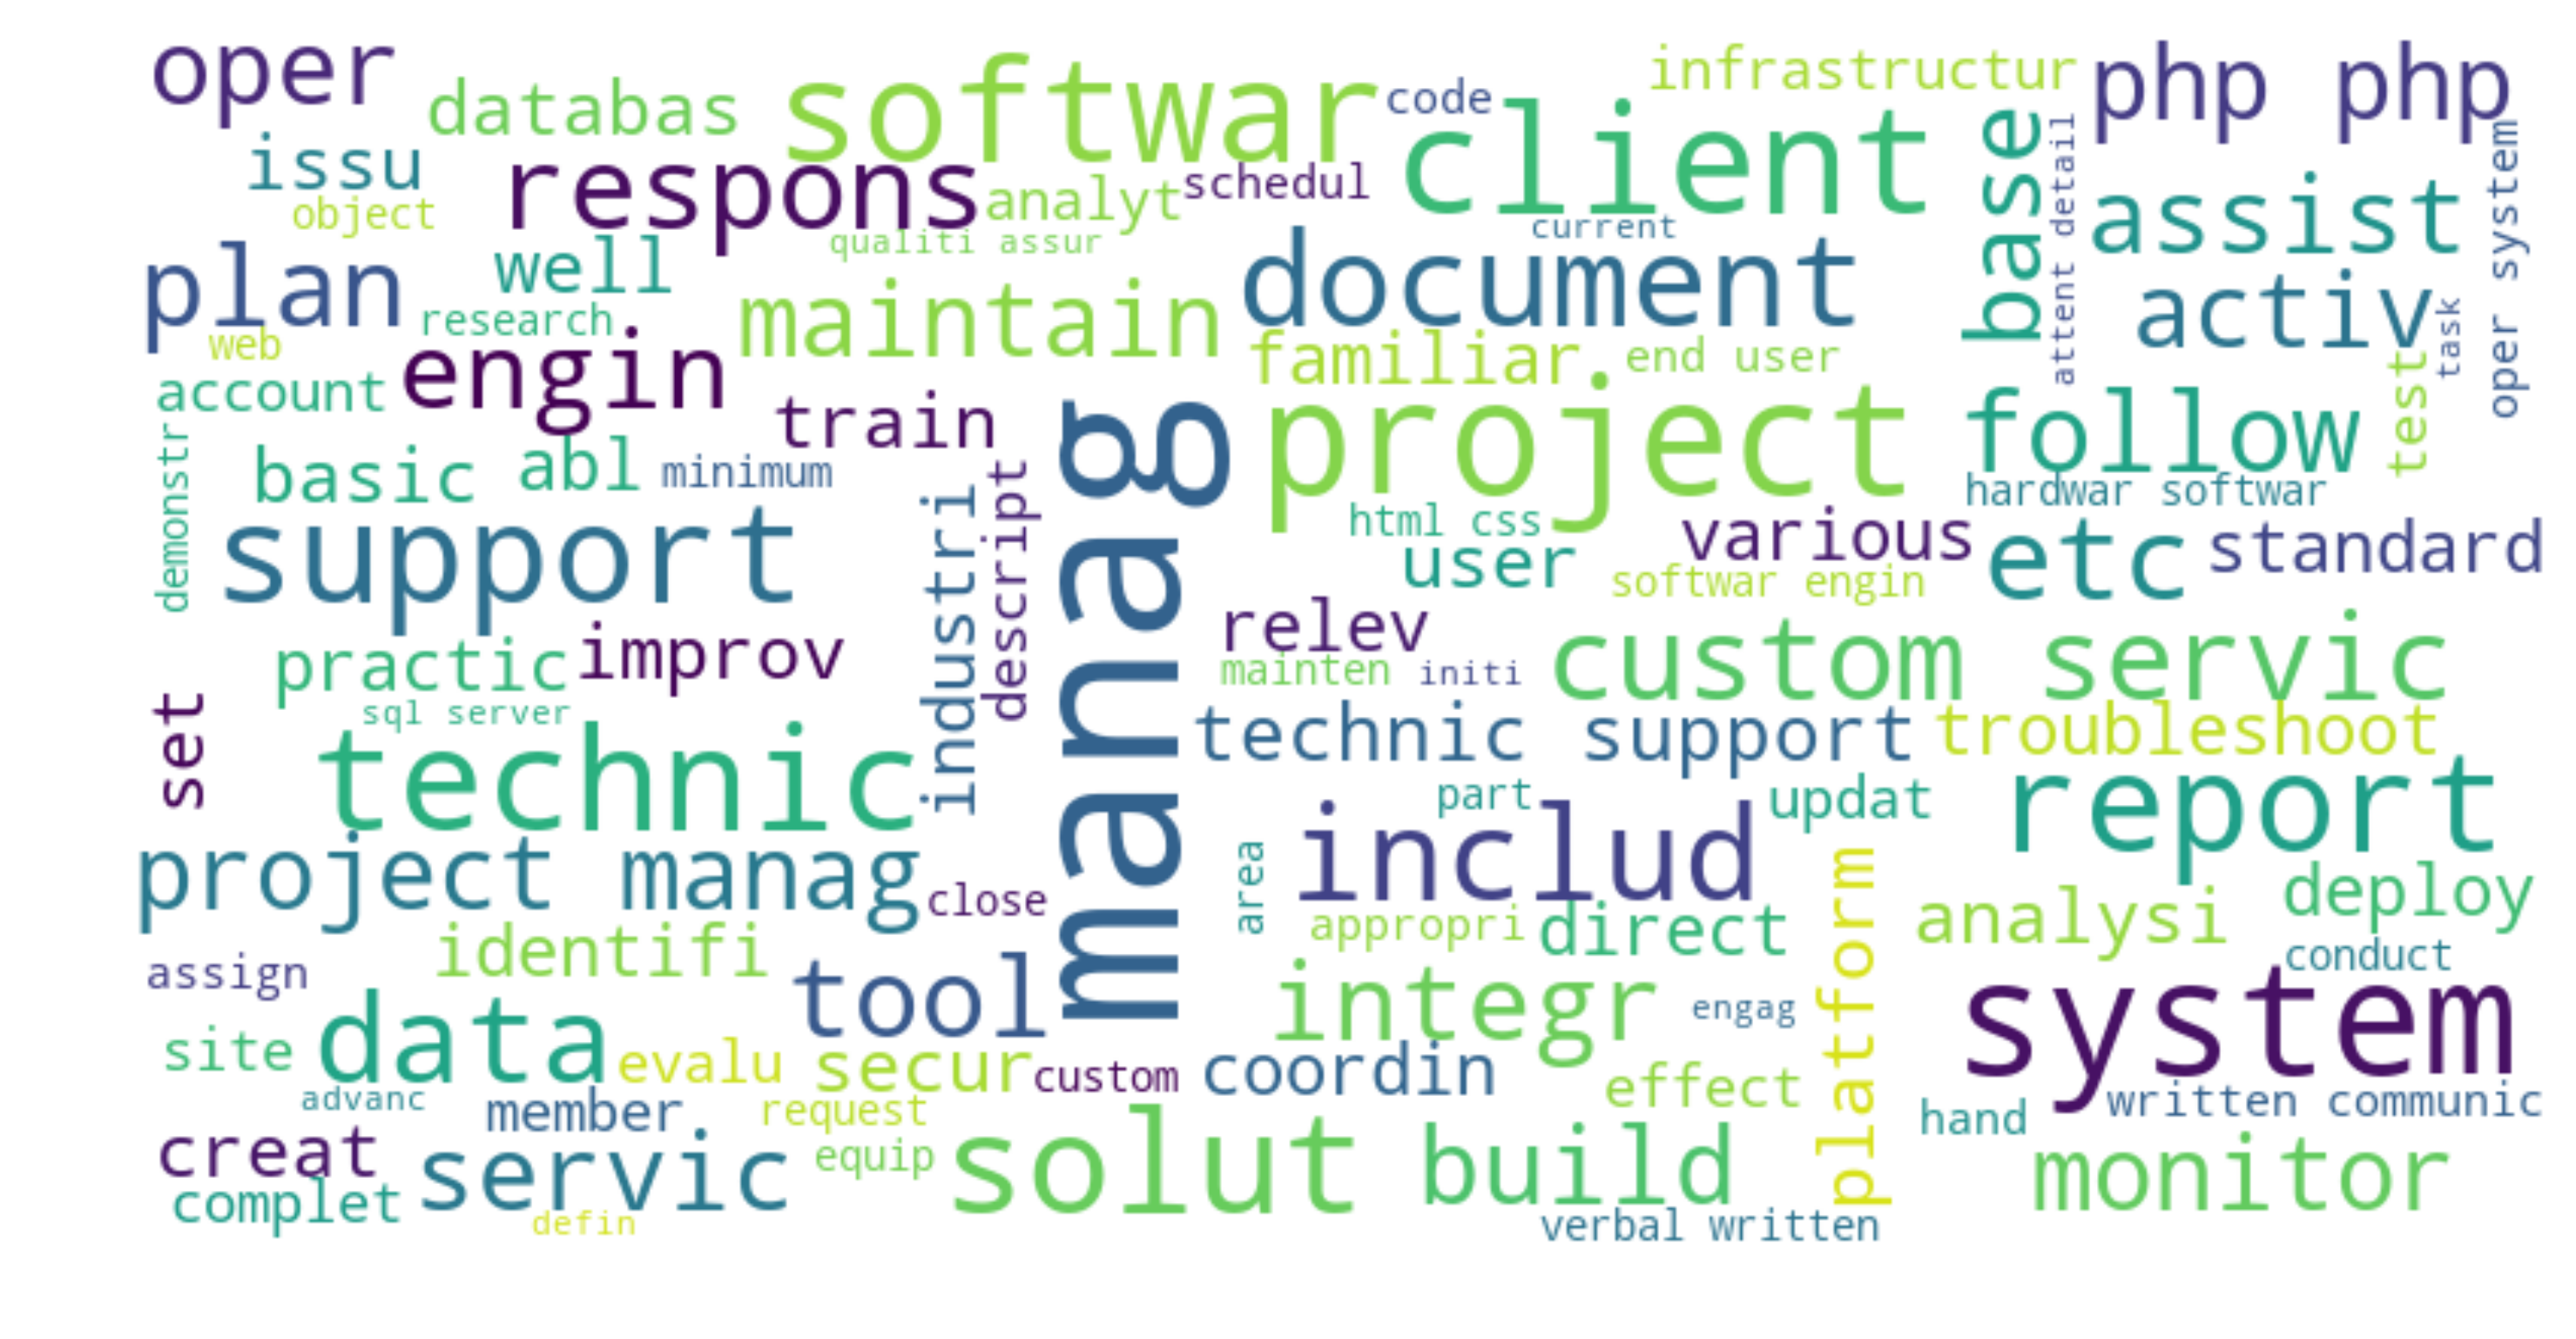

In [17]:
new_txt=' '.join(df['description_cleaned_stemmed_cleaned'])
plot_wordcloud(new_txt)

The new word cloud generated is a lot more specific compared to the first one except this time the words are `stemmed` down to their "base" form.

## Clustering (Topic Modeling): Non Negative Matrix Factorization (NMF)

For the clustering method, the researchers are going to use the non-negative matrix factorization (NMF) of the document matrix. The researchers factor the document matrix into two matrices  WH , where each row in  H  is a component (the job descriptions in this case), and each row in  **W  contains the weights of each component**. The weights are weights of membership that will be used to cluster the job descriptions together.

The processed words will be used to cluster the job descriptions based on skills, technologies and functions. This is done by the custom made package `TopicModel` which uses `TFIDFVectorizer` to vectorize the documents using the `TFIDF` weighting.

`TFIDFVectorizer` has the following parameters:
* `token_pattern` specifies the regex pattern to be used to tokenize the words.
    * The researchers specified a token pattern of `[a-z+#]+`, + and # were included to capture c++ and c#
* `max_df` specifies the maximum percentage of documents that the word can be present in to be vectorized.
    * The researchers specified a percentage of `90` and was arbitrarily specified.
* `min_df` specifies the minimum number of documents that the word must be in to be vectorized.
    * The researchers specified a count of `5` documents as words with less than this are not significant.

`TopicModel` also has the following methods:
* `model_in_range` uses scikit learn's NMF function to cluster the topics for a specified range of k number of clusters.
    * This creates an NMF clustering model for a range of k clusters to be able to see the optimal number of clusters.
    * Parameters used in the NMF function are as follows:
        * `init` initializes the function; `nndsvd` was chosen because it is best used for sparse data.
        * `n_components` specifies the number of clusters; `k` changes for all values in a given range.
        * `random_state` a random seed ensures that the results are repeatable; `1120` was arbitrarily chosen.
* `compute_weights` uses gensim's word2vec function to compute the coherence score for each k number of clusters.
    * Coherence score is a mathematical way of saying that the clustered documents make sense.
* `get_dataframes` uses NMF to cluster the data based on the max weight.
    * Parameters used:
        * `number_topics` 
    * Outputs the following dataframes from the NMF model:
        * `df_topic_words` top defining words of each cluster
        * `df_topic_weights` contains the weight of membership of each document (row) for a given cluster (column)
        * `df_topics` dataframe of cluster labels for each document (row)
        
**The NMF clustering process is as follows:**
1. Create NMF models for a given range of k clusters.
2. Compute the coherence score.
3. Decide the optimal number of clusters based on the coherence score plot.
    * High and stable coherence score with low k is desired.
4. Create the model using the k chosen and export the top 10 words as an excel file.
5. From the excel file inspect the top defining words of each cluster and check if they make sense.
6. If the top defining words "do not make sense" add them to the stop word library.
    * If the word is irrelevant to the topic (not a skill, tech or function).
7. Repeat the process until all the top defining words make sense.
8. Name the clusters based on the top defining words; tag the cluster as ambiguous if the words do not converge.
9. Map the job description back to the cluster labels.
10. Job descriptions with max weight of 0.0 are to be labeled as ambiguous.
11. Repeat the process for ambiguous job descriptions only, keep repeating until the most of the descriptions have been clustered.

In [8]:
model_list = TopicModel(df['description_cleaned_stemmed_cleaned'], 
                        token=r"(?u)[a-z+#]+").model_in_range(mink=10,maxk=30)
top_words, k_values, coherences = TopicModel(df['description_cleaned_stemmed_cleaned'], 
                                             token=r"(?u)[a-z+#]+").compute_weights(model_list,10)

### Internal Validation: Coherence Score

In this section the researchers plotted the coherence score for a range of clusters. High and stable coherence score will be chosen. Additionally, inspection of the top defining words may influence decision in guessing the number of clusters to be used. It can be seen that the coherence plot tends to plateau at higher k number of clusters. The researchers chose a k value near this plateau.

For the first layer of NMF it was seen that `27` clusters still generated 1 coherent cluster and 2 more incoherent clusters. As such 27 was used as this made more sense to the researchers rather than the 24 of suggested by the coherence score plot. 

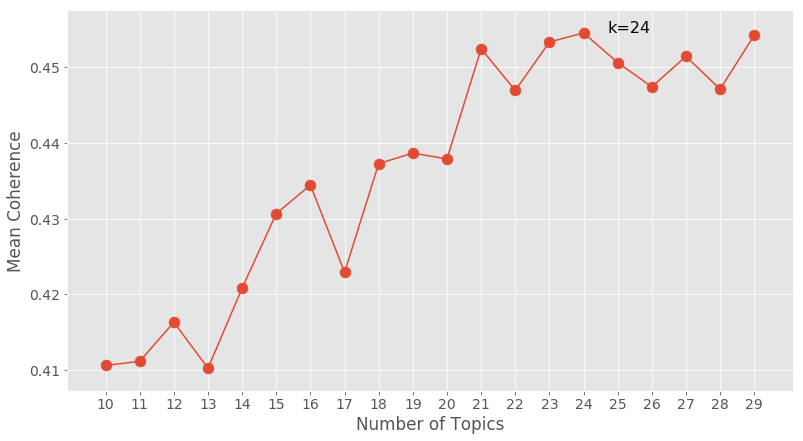

In [52]:
plot_coherence(k_values, coherences)

### Cluster and Extract DataFrames

In this section the researchers clustered the job descriptions. The top words for k clusters are then saved as a CSV file.

In [53]:
df_topic_words, df_topic_weights, df_row_topics = TopicModel(df['description_cleaned_stemmed_cleaned'], low=5).get_dataframes(27,10)
df_topic_words.to_csv('top_10_words_27_clusters_1st_layer.csv', index=False)

Vocabulary has 5226 distinct terms


### Visualizing The Top Defining Words

Below is a table of skills, technologies, functions that define each cluster (given by the columns). The researchers checked these words to see if they are coherent and or converge to one topic (field of IT). It is from this table that the researchers were able to make the stop words library.

In [21]:
pd.read_csv('top_10_words_27_clusters_1st_layer.csv').iloc[0:10]

Topic # 01 Topic # 02 Topic # 03  Topic # 04 Topic # 05 Topic # 06  \
0     servic       test     system         web    japanes    project   
1     status      autom     server  javascript      speak      manag   
2      solut       case  administr         css    analyst       plan   
3       risk         qa     window          js   helpdesk     client   
4     polici     script      linux        html     servic      scope   
5    support     defect   configur         end     associ    coordin   
6    financi   selenium     instal       front  interpret     budget   
7    protect    qualiti    hardwar     angular      bridg   document   
8     origin     manual       oper   framework     market    qualiti   
9        age       plan    monitor       react    account  stakehold   

  Topic # 07 Topic # 08 Topic # 09 Topic # 10  ... Topic # 18  Topic # 19  \
0        sap        php    databas        net  ...       java      electr   
1       abap    languag        sql          c  ...     spring       equip   
2    consult      mysql     server        asp  ...         ee  manufactur   
3         mm    english         ms         vb  ...     hibern       engin   
4         sd    laravel       ssis        mvc  ...  framework      materi   
5       fico        web      queri        sql  ...      strut      mechan   
6       hana   communic       tune  framework  ...       core      compon   
7   configur    symfoni  microsoft     visual  ...       rest      system   
8      modul      relev   recoveri       code  ...       soap     assembl   
9        end      linux      store        web  ...        web    electron   

  Topic # 20 Topic # 21 Topic # 22 Topic # 23 Topic # 24  Topic # 25  \
0      oracl    softwar    support      mobil     market   salesforc   
1         pl       code    technic         io      media         crm   
2    databas      engin     custom    android    content        apex   
3        erp    hardwar       issu        app     social        user   
4       unix     system     servic      swift      digit        forc   
5      linux    technic   helpdesk   platform   campaign  visualforc   
6       tune          c       user          c   communic      integr   
7  administr    qualiti      incid        api       adob        sfdc   
8     packag      solut     resolv      nativ    creativ    configur   
9        rac   maintain     ticket      devic    graphic       cloud   

  Topic # 26 Topic # 27  
0      secur    account  
1     vulner    financi  
2      manag      manag  
3       risk     report  
4      incid     financ  
5      audit      audit  
6     assess     payrol  
7  complianc  inventori  
8     threat     record  
9       siem       bank  

[10 rows x 27 columns]

The researchers then set names to the columns of the top defining words via the cell below.

In [55]:
col_names = '''ambig,qa,system_admin,web_dev,japanese_speaking,project_management,sap_analytics,database_web,database_ms,net_c_vb,network_eng,sales,analytics,customer_service,civil_engineering,cloud_services,recruiter,java_dev,semicon_manuf,database_oracle,ambig,tech_support,mobile_dev,digital_marketing,salesforce,it_sec,fintech'''.split(',')

### Topic Mapping And Filtering

In this section the dataframes are combined so as to map out the labels and weights to the original job posts. Job posts with max weights that are not greater than 0.0 are tagged as ambiguous and are filtered out.

In [56]:
# rename the columns of the generated dataframes according to topic
df_topic_words.columns = col_names
df_topic_weights.columns = col_names

# rename topic dataframe column header
df_row_topics.columns = ['topic']

# create summary dataframe
df_grps = df.join(df_topic_weights)
df_grps = df_grps.join(df_row_topics)
df_grps = df_grps.fillna('blank')
df_grps = df_grps[df_grps['topic']!='blank']

# preliminary weight for initial classification

w_thresh = 0.0
topic_label = []

# check if valid topic grouping via the weight
for row in df_grps[col_names+['topic']].iterrows():
    i = int(row[1][-1])

    if float(row[1][i]) > w_thresh:
        topic_label.append(col_names[i])
    else:
        topic_label.append('ambig')

df_lab = pd.DataFrame(topic_label)
df_lab.columns = ['label']

df_grps = df_grps.join(df_lab)
df_grps.to_csv('it_clustered_1st_layer.csv', index=False)

C:\Users\Nigel\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Re-clustering Ambiguous Topics

Job posts that were labeled as ambiguous are selected and re-clustered again. The researchers kept repeating this process until most of the job descriptions have been clustered.

### NMF: 2nd Layer

There are `3170` job descriptions labeled as ambiguous which will be re-clustered again.

In [58]:
dfa = df_grps[df_grps['label']=='ambig']
dfa = dfa[['title', 'company', 'location', 'description', 'bullets',
       'description_cleaned', 'description_cleaned_stemmed',
       'description_cleaned_stemmed_cleaned']]
dfa = dfa.reset_index(drop=True)
print(dfa.shape)

(3170, 8)


In [6]:
model_list = TopicModel(dfa['description_cleaned_stemmed_cleaned'], 
                        token=r"(?u)[a-z+#]+").model_in_range(mink=15,maxk=30)
top_words, k_values, coherences = TopicModel(dfa['description_cleaned_stemmed_cleaned'],
                                             token=r"(?u)[a-z+#]+").compute_weights(model_list,10)

It can be seen that the coherence score is now relatively higher than in the previous layer. 

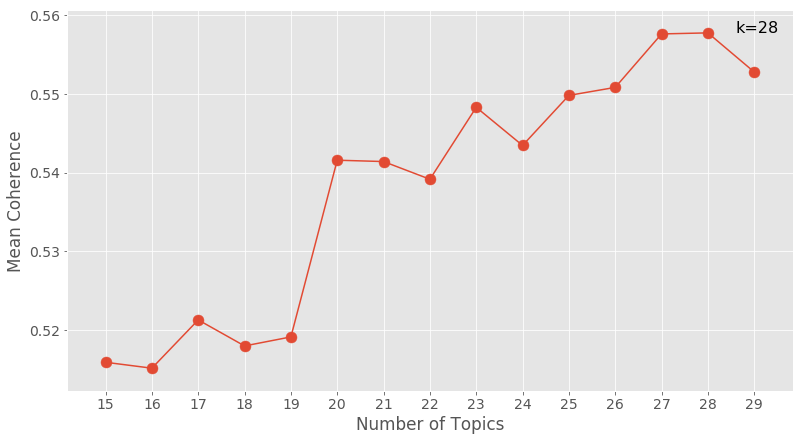

In [61]:
plot_coherence(k_values, coherences)

In [62]:
df_topic_words, df_topic_weights, df_row_topics = TopicModel(dfa['description_cleaned_stemmed_cleaned'], low=5).get_dataframes(28,10)
df_topic_words.to_csv('top_10_words_28_clusters_2nd_layer.csv', index=False)

Vocabulary has 3844 distinct terms


In [10]:
pd.read_csv('top_10_words_28_clusters_2nd_layer.csv').iloc[0:10]

Topic # 01 Topic # 02     Topic # 03  Topic # 04 Topic # 05  Topic # 06  \
0          cloud    japanes        network          js     custom      electr   
1             aw      speak          cisco         web     servic  manufactur   
2         amazon    analyst         switch  javascript       call       equip   
3       platform   helpdesk        firewal         css       issu       engin   
4  infrastructur     servic  infrastructur        html      solut      materi   
5         servic     associ   troubleshoot     angular     resolv     assembl   
6           azur  interpret             ip       react     repres      compon   
7          devop       sale         router       front    contact      method   
8         python     market          engin   framework  satisfact      mechan   
9         deploy    account            wan        node      level   establish   

      Topic # 07 Topic # 08 Topic # 09 Topic # 10  ...    Topic # 19  \
0         system       test        sap    project  ...       support   
1      administr      autom       abap      manag  ...       technic   
2         server     script       hana       plan  ...      helpdesk   
3        hardwar       case         sd     client  ...          user   
4         window     defect        mdg      scope  ...          issu   
5         instal   selenium   configur     budget  ...  troubleshoot   
6       configur       code         mm     report  ...       desktop   
7          linux     manual       fico  stakehold  ...        servic   
8           oper         qa    consult    coordin  ...        ticket   
9  infrastructur       plan         fi    respons  ...        resolv   

   Topic # 20 Topic # 21 Topic # 22 Topic # 23 Topic # 24 Topic # 25  \
0      acquir      oracl    account       sale        sql  construct   
1  settlement    databas    financi     client     server      engin   
2        back         pl     financ  salesforc    databas      civil   
3        bank       unix      audit     market         bi     licens   
4        fast        erp      manag      manag       ssis    autocad   
5        pace        sql     payabl   prospect      queri   structur   
6      custom      linux     report       sell       ssrs       draw   
7        call        rac  inventori        crm  microsoft       site   
8       settl  administr     record      close     servic        cad   
9        loan       tune       bank      solut     report       cost   

  Topic # 26 Topic # 27 Topic # 28  
0     market   wireless    support  
1      media      aruba     polici  
2     social      cisco      solut  
3    content     access     status  
4      digit    network    express  
5       adob        lan    respect  
6   campaign      point      legal  
7   advertis        wan     origin  
8     websit     switch     servic  
9    graphic      secur        age  

[10 rows x 28 columns]

In [3]:
col_names = '''cloud_services,japanese_speaking,network_eng,web_dev,customer_service,semicon_manuf,system_admin,qa,sap_analytics,project_management,java_dev,database_web,analytics,ambig,net_c_vb,recruiter,ambig,it_sec,tech_support,ambig,database_oracle,fintech,sales,database_ms,civil_engineering,digital_marketing,network_eng,ambig'''.split(',')

In [65]:
df_topic_words.columns = col_names
df_topic_weights.columns = col_names
# rename topic dataframe column header
df_row_topics.columns = ['topic']

# create summary dataframe
df_grps = dfa.join(df_topic_weights)
df_grps = df_grps.join(df_row_topics)
df_grps = df_grps.fillna(0.0)
# df_grps = df_grps[df_grps['topic']!='blank']

# preliminary weight for initial classification

w_thresh = 0.0
topic_label = []

# check if valid topic grouping via the weight
for row in df_grps[col_names+['topic']].iterrows():
    i = int(row[1][-1])
    
    if float(row[1][i]) > w_thresh:
        topic_label.append(col_names[i])
    else:
        topic_label.append('ambig')

df_lab = pd.DataFrame(topic_label)
df_lab.columns = ['label']

df_grps = df_grps.join(df_lab)
df_grps.to_csv('it_clustered_2nd_layer.csv', index=False)

In [66]:
df_grps.shape

(3170, 38)

### NMF: 3rd Layer

There are `1792` job descriptions that are still ambiguous and will again be reclustered for the third time.

In [67]:
dfb = df_grps[df_grps['label']=='ambig']
dfb.shape

(1792, 38)

In [4]:
model_list = TopicModel(dfb['description_cleaned_stemmed_cleaned'], token=r"(?u)[a-z+#]+").model_in_range(mink=2,maxk=30)
top_words, k_values, coherences = TopicModel(dfb['description_cleaned_stemmed_cleaned'], token=r"(?u)[a-z+#]+").compute_weights(model_list,10)

It can be seen here that the coherence score has improved for the third layer.

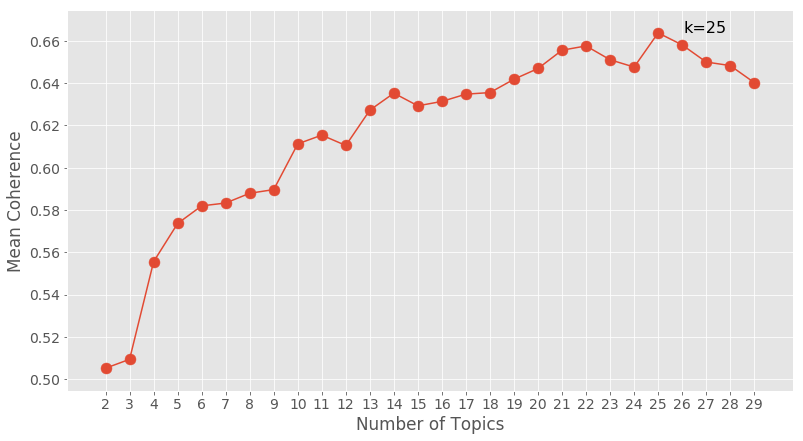

In [69]:
plot_coherence(k_values, coherences)

In [11]:
df_topic_words, df_topic_weights, df_row_topics = TopicModel(dfb['description_cleaned_stemmed_cleaned'], low=5).get_dataframes(25,10)
df_topic_words.to_csv('top_10_words_25_clusters_3rd_layer.csv', index=False)

In [12]:
pd.read_csv('top_10_words_25_clusters_3rd_layer.csv').iloc[0:10]

Topic # 01 Topic # 02    Topic # 03  Topic # 04 Topic # 05 Topic # 06  \
0    support     custom        system          js      engin     market   
1     polici     servic       hardwar  javascript     electr      media   
2     status       call        instal         web  construct     social   
3      solut     acquir     administr         css      civil    content   
4    express     repres      configur        html    autocad      digit   
5    respect       care        server     angular     licens   advertis   
6        age    contact       network       react   electron   campaign   
7     origin       voic  troubleshoot       front     mechan     websit   
8       risk       back        window        node       draw       adob   
9     inclus     action         linux         end         ms   strategi   

  Topic # 07   Topic # 08          Topic # 09 Topic # 10  ... Topic # 16  \
0       test          sap                 php      oracl  ...    softwar   
1      autom          mdg             languag    databas  ...       code   
2     script         abap               mysql       unix  ...      engin   
3       case  managemento             english         pl  ...    qualiti   
4   selenium     configur             laravel      linux  ...    technic   
5     defect           fi             mainten        sql  ...      solut   
6     manual           sd             network        rac  ...      debug   
7       plan         hana            communic  administr  ...          c   
8         qa         fico  troubleshootingwil       suit  ...     system   
9    regress           mm             softwar      clone  ...      write   

  Topic # 17 Topic # 18 Topic # 19 Topic # 20 Topic # 21 Topic # 22  \
0    project      manag      secur     server       java       sale   
1      manag     servic      audit        sql     spring     market   
2       plan  administr     vulner    databas         ee     client   
3     client      excel     assess         bi     hibern       sell   
4      scope       oper    network       ssis    android     custom   
5    coordin      asset    control     window  framework      close   
6     report   communic  complianc  microsoft          c     negoti   
7    technic      level     system        mdx        web      manag   
8   document      train     penetr     servic        sql   prospect   
9    schedul       area      devic       ssrs       soap    respons   

  Topic # 23  Topic # 24 Topic # 25  
0        web         net  salesforc  
1      creat           c        crm  
2  shortlist         asp       user  
3      becom          vb       sfdc  
4     better         mvc  administr  
5     client  sharepoint       forc  
6       info         xml       apex  
7        end         wpf    support  
8     improv        html      train  
9       comw          ms       amen  

[10 rows x 25 columns]

In [71]:
dfb = dfb[['title', 'company', 'location', 'description', 'bullets',
       'description_cleaned', 'description_cleaned_stemmed',
       'description_cleaned_stemmed_cleaned']]
dfb = dfb.reset_index(drop=True)

In [13]:
col_names = '''ambig,customer_service,system_admin,web_dev,ambig,digital_marketing,qa,sap_analytics,database_web,database_oracle,analytics,tech_support,ambig,fintech,recruiter,ambig,project_management,ambig,it_sec,database_ms,java_dev,sales,ambig,net_c_vb,salesforce'''.split(',')

In [73]:
# rename the columns of the generated dataframes according to topic
df_topic_words.columns = col_names
df_topic_weights.columns = col_names

# rename topic dataframe column header
df_row_topics.columns = ['topic']

# create summary dataframe
df_grps = dfb.join(df_topic_weights)
df_grps = df_grps.join(df_row_topics)
df_grps = df_grps.fillna(0.0)
# df_grps = df_grps[df_grps['topic']!='blank']

# preliminary weight for initial classification

w_thresh = 0.0
topic_label = []

# check if valid topic grouping via the weight
for row in df_grps[col_names+['topic']].iterrows():
    i = int(row[1][-1])
    
    if float(row[1][i]) > w_thresh:
        topic_label.append(col_names[i])
    else:
        topic_label.append('ambig')

df_lab = pd.DataFrame(topic_label)
df_lab.columns = ['label']

df_grps = df_grps.join(df_lab)
df_grps.to_csv('it_clustered_3rd_layer_tresh.csv', index=False)

In [74]:
df_grps.shape

(1792, 35)

### NMF: 4th Layer

For the 4th (and final layer) the researchers are left with 1222 job descriptions still labeled as ambiguous. This is the final layer because the topic coherence after this layer was very ambiguous to the researchers. 

In [75]:
dfc = df_grps[df_grps['label']=='ambig']
dfc.shape

(1222, 35)

In [14]:
dfc = dfc[['title', 'company', 'location', 'description', 'bullets',
       'description_cleaned', 'description_cleaned_stemmed',
       'description_cleaned_stemmed_cleaned']]
dfc = dfc.reset_index(drop=True)

In [ ]:
model_list = TopicModel(dfc['description_cleaned_stemmed_cleaned'], token=r"(?u)[a-z+#]+").model_in_range(mink=2,maxk=30)
top_words, k_values, coherences = TopicModel(dfc['description_cleaned_stemmed_cleaned'], token=r"(?u)[a-z+#]+").compute_weights(model_list,10)

The coherence score is now much higher than in the previous runs. However is still very unstable. 

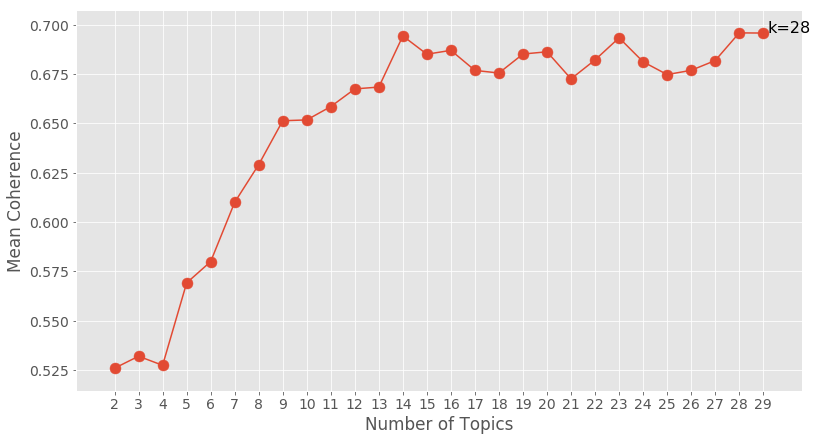

In [77]:
plot_coherence(k_values, coherences)

In [79]:
df_topic_words, df_topic_weights, df_row_topics = TopicModel(dfb['description_cleaned_stemmed_cleaned'], low=5).get_dataframes(28,10)
display(df_topic_words)
df_topic_words.to_csv('top_10_words_28_clusters_4th_layer.csv', index=False)

Vocabulary has 2653 distinct terms


Topic # 01 Topic # 02    Topic # 03  Topic # 04   Topic # 05 Topic # 06  \
0     support     custom        system          js      softwar     market   
1      polici     servic       hardwar  javascript        engin      media   
2  subsidiari       call        server         web      hardwar     social   
3      affili     acquir     administr         css            c    content   
4    categori     repres        instal        html       associ      digit   
5       legal    contact      configur     angular      languag   advertis   
6      invest       care       network       react     programm   campaign   
7       truli       voic        window       front     communic     websit   
8     express       back         linux        node      specifi   strategi   
9     premium     action  troubleshoot         end  tasksdesign   communic   

  Topic # 07   Topic # 08          Topic # 09 Topic # 10  ...  \
0       test          sap                 php      oracl  ...   
1      autom          mdg             languag    databas  ...   
2     script         abap               mysql       unix  ...   
3       case  managemento             english         pl  ...   
4   selenium     configur             laravel        sql  ...   
5     defect           fi             mainten      linux  ...   
6     manual           sd             network        rac  ...   
7       plan         hana  troubleshootingwil  administr  ...   
8         qa         fico               appli       suit  ...   
9    regress           mm            communic      clone  ...   

          Topic # 19 Topic # 20 Topic # 21 Topic # 22           Topic # 23  \
0             modifi     server       java       sale                  web   
1             mechan        sql     spring     market                creat   
2              equip    databas         ee     client            shortlist   
3        clientstest         bi     hibern       sell                becom   
4     researchproduc       ssis    android     custom               better   
5           timescal     window  framework      close                 info   
6               safe  microsoft          c     negoti               client   
7                aid        mdx        web   prospect                  end   
8  suppliersundertak       ssrs        sql    respons       compensational   
9      softwareliais     servic       soap      order  advancementcollabor   

   Topic # 24 Topic # 25 Topic # 26 Topic # 27 Topic # 28  
0         net  salesforc      secur      engin      tower  
1           c        crm      audit     electr      solut  
2         asp       user     vulner  construct     commit  
3          vb       sfdc     assess      civil       agil  
4         mvc  administr    network    autocad      scrum  
5  sharepoint       forc    control     licens    practic  
6         xml       apex  complianc   electron     status  
7         wpf    support     penetr       draw     talent  
8        html       amen       risk         ms     servic  
9          ms      train     system       cost     cultur  

[10 rows x 28 columns]

In [15]:
col_names = 'ambig,customer_service,system_admin,web_dev,ambig,digital_marketing,qa,sap_analytics,database_web,database_oracle,analytics,tech_support,ambig,fintech,recruiter,ambig,project_management,ambig,ambig,database_ms,java_dev,sales,ambig,net_c_vb,salesforce,it_sec,civil_engineering,ambig'.split(',')

In [84]:
# rename the columns of the generated dataframes according to topic
df_topic_words.columns = col_names
df_topic_weights.columns = col_names

# rename topic dataframe column header
df_row_topics.columns = ['topic']

# create summary dataframe
df_grps = dfc.join(df_topic_weights)
df_grps = df_grps.join(df_row_topics)
df_grps = df_grps.fillna(0.0)
# df_grps = df_grps[df_grps['topic']!='blank']

# preliminary weight for initial classification

w_thresh = 0.0
topic_label = []

# check if valid topic grouping via the weight
for row in df_grps[col_names+['topic']].iterrows():
    i = int(row[1][-1])
    
    if float(row[1][i]) > w_thresh:
        topic_label.append(col_names[i])
    else:
        topic_label.append('ambig')

df_lab = pd.DataFrame(topic_label)
df_lab.columns = ['label']

df_grps = df_grps.join(df_lab)
df_grps.to_csv('it_clustered_4th_layer.csv', index=False)

In [85]:
df_grps.shape

(1222, 38)

In [86]:
df_rej = df_grps[df_grps['label']=='ambig']
df_rej.shape

(851, 38)

The researchers at this point have decided to forego any more clustering due to diminishing returns. Final cluster results show that 851 of the 5600 job posts remain to be ambiguous after 4 NMF clustering runs.

## Post Clustering Analysis

### Load And Combine Clustering Results

The code blow loads the result csv files and combined them all together into one main result dataframe.

In [4]:
# Load Resulting Clusters at Different Layers
df1 = pd.read_csv('it_clustered_1st_layer.csv')
df2 = pd.read_csv('it_clustered_2nd_layer.csv')
df3 = pd.read_csv('it_clustered_3rd_layer.csv')
df4 = pd.read_csv('it_clustered_4th_layer.csv')

# Remove Ambiguous Descriptions at Different Layers
df1 = df1[df1['label']!='ambig']
print(f'Shape after removing ambiguous from Layer 1 Clusters: {df1.shape}')
df2 = df2[df2['label']!='ambig']
print(f'Shape after removing ambiguous from Layer 2 Clusters: {df2.shape}')
df3 = df3[df3['label']!='ambig']
print(f'Shape after removing ambiguous from Layer 3 Clusters: {df3.shape}')
df4 = df4[df4['label']!='ambig']
print(f'Shape after removing ambiguous from Layer 4 Clusters: {df4.shape}')

df_main = pd.concat([df1,df2,df3,df4]).fillna(0)
df_main.head()

Shape after removing ambiguous from Layer 1 Clusters: (2473, 37)
Shape after removing ambiguous from Layer 2 Clusters: (1378, 38)
Shape after removing ambiguous from Layer 3 Clusters: (570, 35)
Shape after removing ambiguous from Layer 4 Clusters: (371, 38)


C:\Users\Nigel\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



ambig   ambig.1  ambig.2  ambig.3  ambig.4  ambig.5  ambig.6  ambig.7  \
1  0.013458  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
2  0.018038  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
3  0.017545  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
4  0.023870  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
5  0.003913  0.109127      0.0      0.0      0.0      0.0      0.0      0.0   

   analytics                                            bullets  ...  \
1   0.059244  ['Develop scripts to gather data for mContent ...  ...   
2   0.017742  ['Develop and maintain web application using R...  ...   
3   0.020857  ['Develop and maintain API-based backend appli...  ...   
4   0.008649  ['Oversees the work of other individuals in th...  ...   
5   0.022228  ['Primary Skills: Asp .Net, MVC 4.0, WCF, jQue...  ...   

   recruiter     sales salesforce  sap_analytics  semicon_manuf  system_admin  \
1        0.0  0.000000   0.000000        0.00015        0.00000      0.015876   
2        0.0  0.000600   0.000000        0.00000        0.00000      0.005455   
3        0.0  0.000299   0.000000        0.00000        0.00000      0.000000   
4        0.0  0.000000   0.000000        0.00000        0.00562      0.010283   
5        0.0  0.000000   0.000242        0.00000        0.00000      0.003213   

   tech_support                                   title topic   web_dev  
1      0.001702                Social Crawler Developer    23  0.003099  
2      0.004686               Senior Frontend Developer    23  0.053095  
3      0.005916                Senior Backend Developer    23  0.025960  
4      0.089035              Operations Support Manager    21  0.000000  
5      0.000000  Eastwood City - Software Engineer .NET     9  0.008716  

[5 rows x 44 columns]

### Sanity Check: Weights

In this section the researchers plot the distribution of weight membership for each cluster. The idea here is that if the the job posts truly belong to the specified cluster then the distribution of weights of **the same data** for a different cluster should have a large density at 0.0 weight with minimal overlap with the main cluster. 

*In other words if a set of job posts from cluster x truly belong to cluster x then grouping them into cluster y should result in a kde plot where the amplitude is very high at 0 and with a very tight standard deviation to avoid overlaps with the original cluster.*

Through these plots the researchers will be able to identify the clusters that have overlaps; which may indicate either poor cleaning, or that the skills for both clusters simply overlap due to the nature of the work. Due to high amount of clusters generated the researchers will only be showing a few of the kde plots that yielded interesting insights.

### Web Developer

It can be seen here that the web developer position has some slight overlaps with the database_web cluster. This is indicated by the large standard deviation of weight for the database_web cluster. Additionally the database_web cluster has a relatively low kde amplitude at weight 0.0 which supports the idea that indeed there's a bit of mixing for this situation. However, the mixing is valid as database web are simply databases that are liked to a database and as sich it follows that some skills will overlap.

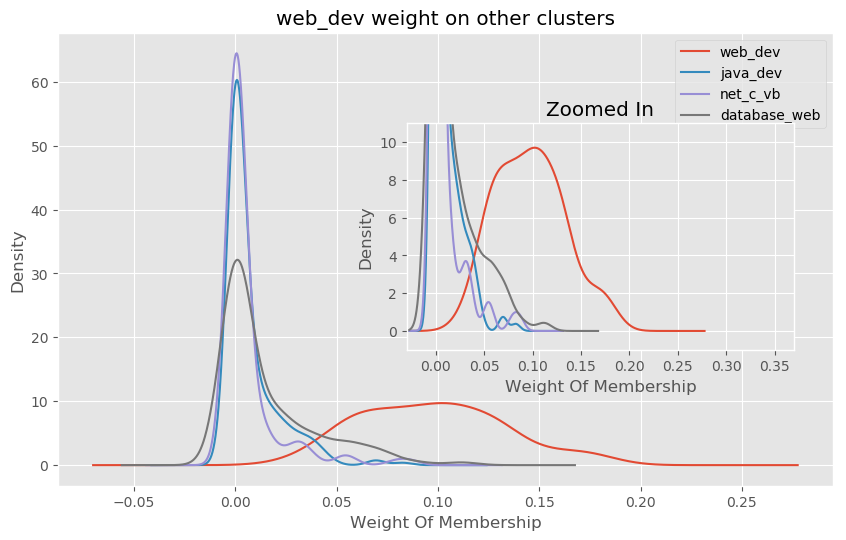

In [5]:
kde_weights(df_main, 'web_dev', ['java_dev', 'net_c_vb','database_web'], zoom=[-1,11,-0.03,0.37], posi=[0.45,0.3,0.5,0.5])

### Japanese Speaking:

The japanese speaking cluster is very well defined in that it has a weight distribution that is centered around 0.35. The presence of a 2 gaussian like distribution indicates that there are some noise and misclassification that occured. This is further verified by the fact that other clusters have some spikes on the left tail end of the kde plot.

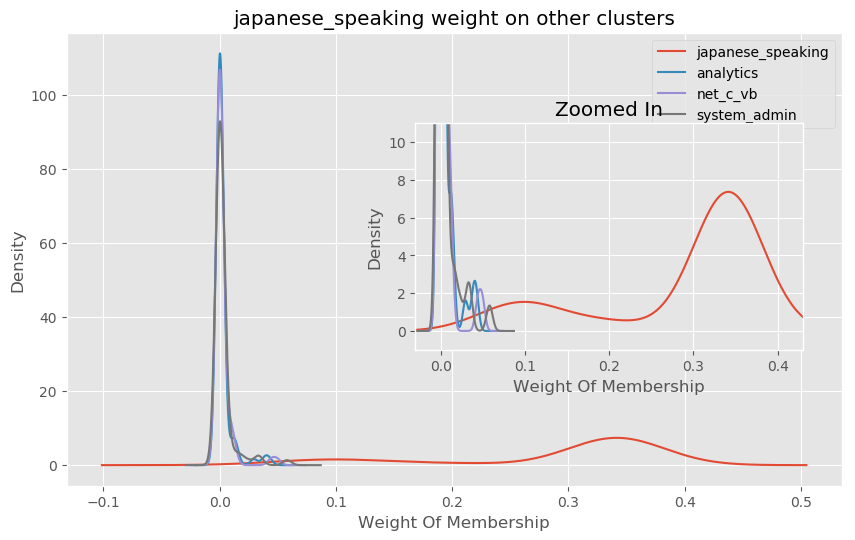

In [6]:
kde_weights(df_main, 'japanese_speaking', ['analytics', 'net_c_vb', 'system_admin'], zoom=[-1,11,-0.03,0.43], posi=[0.45,0.3,0.5,0.5])

### Database Admin: Oracle

It can be seen from the plot below that database admin skills for microsoft has high overlap with the database admin skills for oracle; which is not surprising since both technologies are the same, just supplied by different providers. 

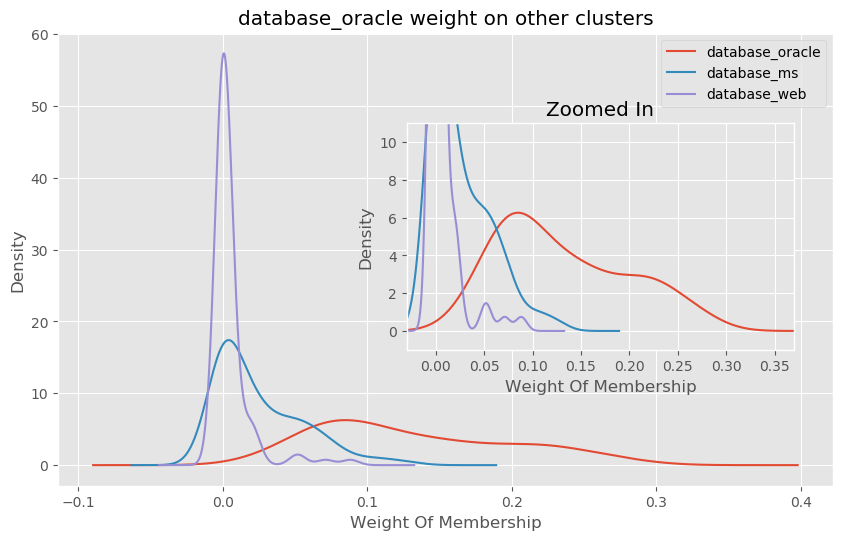

In [7]:
kde_weights(df_main, 'database_oracle', ['database_ms', 'database_web'], zoom=[-1,11,-0.03,0.37], posi=[0.45,0.3,0.5,0.5])

## Results

### Comparison Cloud

Below are visuals the researchers generated using R's comparison cloud function. The researchers were not able to find a comparison cloud for python and as such have requested to use R for the visualization of the results.

The documentation is as follows:

Let $p_{i,j}$ be the rate at which word i occurs in document $j$, and $p_j$ be the average across documents $\left(\sum_ip_{i,j}/ndocs \right)$. The size of each word is mapped to its maximum deviation $( \max_i(p_{i,j}-p_j) )$, and its angular position is determined by the document where that maximum occurs.

Note that the words in the comparison cloud were shortened to allow for better clustering results. The following visuals give a good overview of the Philippine's IT industry (skill / tech / function wise) which can help job seekers in matching their skills with the demand of the industry.

<img src="ComparisonClouds/ccloud1.png">
<img src="ComparisonClouds/ccloud5.png">
<img src="ComparisonClouds/ccloud3.png">
<img src="ComparisonClouds/ccloud4.png">
<img src="ComparisonClouds/ccloud2.png">

### Overall Stats

Below are the rankings of each skill cluster. 

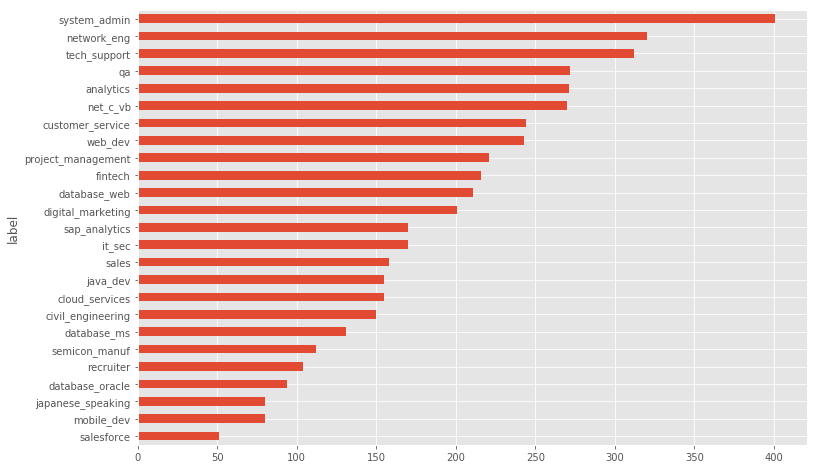

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
df_lab_cnt = df_main.groupby('label').count()
df_lab_cnt = df_lab_cnt.sort_values(by='title',ascending=True)
df_lab_cnt['title'].plot(kind='barh', ax=ax)

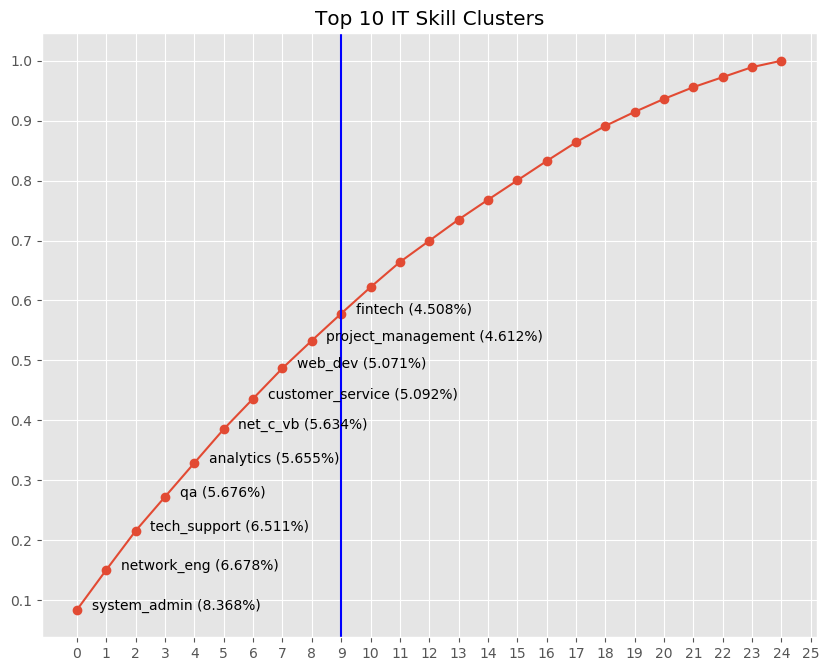

In [9]:
top_clusters(df_lab_cnt)

## Conclusion

The researchers were able to identify **25 skill clusters** for the Philippine's IT industry, the top 3 being "system_admin", "network_eng" and "tech_support". The top 10 skill clusters account for almost 60% of the IT related job posts. This is true only for the second half of 2019 as the data was scraped during early to mid June. Review of the weight distribution in each cluster show relatively good separation on the weights of membership. With that said, there are several overlapping skill clusters which share skillsets as is the case in database administration. 

A surprising discovery was that there exists a japanese speaking cluster for the IT industry, and that there were some engineering fields that got mixed in the during the scraping process. Another insight worth mentioning is the absence of popular tech such as Fortran (old tech), MATLAB (non-industry standard) and Python (diverse application across many clusters) in the top defining words. **This suggests that these words do not define any cluster in the Philippines IT industry. It DOES NOT mean that these technologies are obsolete / not in demand.**

Overall, the results can still further be improved via more text cleaning techniques. This is true because just the mere act of adding to the stop words library actually improves the coherence score.

## Recommendation to Stakeholders

**Students,** let this serve as an overview of the IT industry climate here in the Philippines; to allow for better preparation in line with the demand.

**Job Seekers,** focus on the developing skills that belong to the top 10 IT skill clusters as these will offer more opportunites; or go for a very niche market (such as Japanese speaking) as these niche markets offer larger compensation.

**Educators,** align the curriculum with what is in demand to better prepare the workforce of the Philippines.

**Employers,** create a convention / standard for making a job post so as to make it easier to get the data.

## References

* Greene, D. <i>Parameter Selection for NMF.</i> Retrieved July 13, 2019, from https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb
* Li, T., & Ding, C. C. (2018). <i>Nonnegative matrix factorizations for clustering: A survey.</i> In Data Clustering (pp. 149-176). Chapman and Hall/CRC.
* Suarez, I. (2017, February 1). <i>Study: Over 50% of Pinoy IT students lack programming skills.</i> Retrieved July 13, 2019, from http://newsbytes.ph/2017/02/01/study-over-50-of-pinoy-it-students-lack-programming-skills/?fbclid=IwAR0FAeP36UtyvkdE24D_7cgbDlmExITMY0KUK6mM0gbykYkMTcchfstjBuQ
* Tang, J., Ceng, X., & Peng, B. (2011, July). <i>New methods of Data Clustering and classification based on NMF.</i> In 2011 International Conference on Business Computing and Global Informatization (pp. 432-435). IEEE.
* <i>what is difference between text classification and topic models?</i> Retrieved July 13, 2019, from https://datascience.stackexchange.com/questions/962/what-is-difference-between-text-classification-and-topic-models
 

## Acknowledgements 

The group would like to thank the following people for their significant input in this work:

* Christian Alis, Ph.D.
* Eduardo David, Jr.
* Erika Fille Legara, Ph.D.
* MSDS 2019
* MSDS 2020
* Lester Nacu